<a href="https://colab.research.google.com/github/Suvoo/Daad-Wise-prep/blob/main/JaxQuickstart_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The goal of this notebook will be to gain the knowledge necessary to build complex ML models (such as NNs) and train them in parallel on multiple devices! 💻💻💻

In [1]:
# Let's import the necessary packages
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap #parallelize-->pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

## The Problem of State
JAX ❤️ Pure Functions => JAX "!❤️" State.

In [ ]:
# 1) We've seen in the last notebook/video that impure functions are problematic.

g = 0.  # state

# We're accessing some external state in this function which causes problems
def impure_uses_globals(x):
    return x + g

# JAX captures the value of the global/state during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global/state!
g = 10.

# Subsequent runs may silently use the cached value of the globals/state
print ("Second call: ", jit(impure_uses_globals)(5.))

First call:  4.0
Second call:  5.0


In [ ]:
# 2) We've also seen this pattern how JAX's PRNG 
# (which is not stateful in contrast to NumPy's PRNG) is handling state.

seed = 0
state = jax.random.PRNGKey(seed)

# We input the state, we somehow manipulate it and we return it back.
# The state is not saved internally.
state1, state2 = jax.random.split(state)  # recall: key/subkey was the terminology we used

In [ ]:
# Let's now explictly address and understand the problem of state!
# Why? 
# Well, NNs love statefulness: model params, optimizer params, BatchNorm, etc.
# and we've seen that JAX seems to have a problem with it.

class Counter:
    """A simple counter."""
    def __init__(self):
        self.n = 0
    def count(self) -> int:
        """Increments the counter and returns the new value."""
        self.n += 1
        return self.n
    def reset(self):
        """Resets the counter to zero."""
        self.n = 0
    
counter =  Counter()

for _ in range(3): # works fine
    print(counter.count())



1
2
3


In [ ]:
counter.reset()
fast_count = jit(counter.count)

for _ in range(3): # not working
    print(fast_count()) # as count is not pure, so jit fails...cache "1" from first time

1
1
1


In [ ]:
from jax import make_jaxpr # use jaxpr to understand why this is happening

counter.reset()
print(make_jaxpr(counter.count)()) # return 1

{ lambda ; . let  in (1,) }


In [ ]:
counter.reset()
counter.count() # --> modifies state to 1
fast_count = jit(counter.count)

for _ in range(3): # not working
    print(fast_count())

2
2
2


In [ ]:
from jax import make_jaxpr # use jaxpr to understand why this is happening

counter.reset()
counter.count()
print(make_jaxpr(counter.count)()) # return 2

{ lambda ; . let  in (2,) }


 Solution to avoid creating impure function

In [ ]:
CounterState =  int # implemented as a simple integer

class CounterV2:
    def count(self, n: CounterState) -> Tuple[int, CounterState]:
        # You could just return n+1, but here we separate its role as 
        # the output and as the counter state for didactic purposes.
        # (as the output may be some arbitrary function of state in general case)
        return n+1,n+1

    def reset(self) -> CounterState:
        return 0

counter = CounterV2()
state = counter.reset() # notice how reset() now returns state (external vs internal imp)

for _ in range(3):
    value,state =  counter.count(state)
    print(value,state)

1 1
2 2
3 3


In [ ]:
state = counter.reset()
fast_count = jit(counter.count)

for _ in range(3):
    value,state =  fast_count(state)
    print(value,state)

1 1
2 2
3 3


In [ ]:
from jax import make_jaxpr # use jaxpr to understand why this is happening

counter.reset()
print(make_jaxpr(counter.count)(10)) # 

{ lambda ; a:i32[]. let b:i32[] = add a 1; c:i32[] = add a 1 in (b, c) }


In summary we used the following rule to convert a stateful class:

```python
class StatefulClass

    state: State

    def stateful_method(*args, **kwargs) -> Output:
```

into a class of the form:

```python
class StatelessClass

    def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

Nice - we figured an equivalent way to handle states without introducing the side-effects.

This brings us 1 step closer to building neural networks! 🥳

We still need to find a way to handle gradients when dealing with big NNs.

### Enter PyTree 🌳
Before we start - why are gradients a problem in the first place?

In [ ]:
f = lambda x, y, z, w: x**2 + y**2 + z**2 + w**2  # + 175B params more (minus 4)

# JAX: .backward() is not that great
# also JAX:
x, y, z, w = [1.]*4
dfdx, dfdy, dfdz, dfdw = grad(f, argnums=(0, 1, 2, 3))(x, y, z, w) # these have a lot of paarameters and donot scale
print(dfdx, dfdy, dfdz, dfdw)

# Great now we just need to update our params!
# lr = 0.001
# x -= lr*dfdx
# y -= lr*dfdy
# ... (175B lines later)
# w -= lr*dfdw

# No, no, no. 
# We do have a better way.

2.0 2.0 2.0 2.0


No, no, no. We do have a better way!

We want to, more naturally, wrap our params in some more complex data structures like dictionaries, etc.

JAX knows how to deal with these! The answer is called a PyTree.

In [ ]:
 # A contrived example for pedagogical purposes
# (if your mind needs to attach some semantics to parse this - treat it as model params)
pytree_example = [
    [1, 'a', object()], # pytree 1 with 3 leaves
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in pytree_example:
    leaves = jax.tree_leaves(pytree)  # handy little function
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7fc99f412770>]   has 3 leaves: [1, 'a', <object object at 0x7fc99f412770>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


In [ ]:
# How do we manipulate PyTrees?

list_of_lists = [
    {'a': 3},
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

# For single arg functions use tree_map
# tree_map iterates through leaves and applies the lambda function
print(jax.tree_map(lambda x: x*2, list_of_lists))

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


In [ ]:
another_list_of_lists = list_of_lists
print(jax.tree_multimap(lambda x, y: x+y, list_of_lists, another_list_of_lists))

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


In [ ]:
# PyTrees need to have the same structure if we are to apply tree_multimap!
another_list_of_lists = deepcopy(list_of_lists)
another_list_of_lists.append([23]) # change not possinle
print(jax.tree_multimap(lambda x, y: x+y, list_of_lists, another_list_of_lists))

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


ValueError: ignored

## Less contrived example: training a toy MLP (multi-layer perceptron) model

In [ ]:
def init_mlp_params(layer_widths):
    params = []

    # Allocate weights and biases (model parameters)
    # Notice: we're not using JAX's PRNG here - doesn't matter for this simple example
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                biases=np.ones(shape=(n_out,))
        )
    )

    return params

# Instantiate a single input - single output, 3 layer (2 hidden layers) deep MLP
params = init_mlp_params([1, 128, 128, 1])

# Another example of how we might use tree_map - verify that shapes make sense:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [ ]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

    return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)  # MSE loss

lr = 0.0001

@jit  # notice how we do jit only at the highest level - XLA will have plenty of space to optimize
def update(params, x, y):

    # Note that grads is a pytree with the same structure as params.
    # grad is one of the many JAX functions that has built-in support for pytrees!
    grads = jax.grad(loss_fn)(params, x, y)

    # Task: analyze grads and make sure it has the same structure as params

    # SGD update
    return jax.tree_multimap(
        lambda p, g: p - lr * g, params, grads  # for every leaf i.e. for every param of MLP
    )

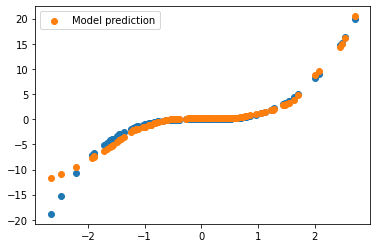

In [ ]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 3  # let's learn how to regress a parabola

# Task experiment a bit with other functions (polynomials, sin, etc.)

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)  # again our lovely pattern

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

|trained our first neural network! 🥳🥳🥳

In order to be able to build NN libs and layers such as nn.Linear (PyTorch syntax), etc. we need a couple more tricks up our sleeves! 🔥

## Custom PyTrees ⚙️

In [16]:
class MyContainer:  # this could be a linear layer a conv layer or whatever
    """A named container."""
    def __init__(self, name: str, a: int, b: int, c: int):
        self.name = name
        self.a = a
        self.b = b
        self.c = c

In [17]:
example_pytree = [MyContainer('Alice', 1, 2, 3), MyContainer('Bob', 4, 5, 6)]  # 8 leaves? Right? Noup.

leaves = jax.tree_leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7fc987e4e6d0>, <__main__.MyContainer object at 0x7fc987e4e750>]
 has 2 leaves:
 [<__main__.MyContainer object at 0x7fc987e4e6d0>, <__main__.MyContainer object at 0x7fc987e4e750>]


In [18]:
print(jax.tree_map(lambda x: x + 1, example_pytree))  # this will not work :/ it'd be nice if it did

TypeError: ignored

### Solution

In [19]:
# Let's get it to work! We'll need to define 2 functions (flatten/unflatten)

def flatten_MyContainer(container):
    """Returns an iterable over container contents, and aux data."""
    flat_contents = [container.a, container.b, container.c]

    # we don't want the name to appear as a child, so it is auxiliary data.
    # auxiliary data is usually a description of the structure of a node,
    # e.g., the keys of a dict -- anything that isn't a node's children.
    aux_data = container.name

    return flat_contents, aux_data

def unflatten_MyContainer(aux_data, flat_contents):
    """Converts aux data and the flat contents into a MyContainer."""
    return MyContainer(aux_data, *flat_contents)

# Register a custom PyTree node
jax.tree_util.register_pytree_node(MyContainer, flatten_MyContainer, unflatten_MyContainer)

In [20]:
leaves = jax.tree_leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7fc987e4e6d0>, <__main__.MyContainer object at 0x7fc987e4e750>]
 has 6 leaves:
 [1, 2, 3, 4, 5, 6]


In [22]:
# Let's try applying tree map again
result = jax.tree_map(lambda x: x + 1, example_pytree)
print(jax.tree_leaves(result))  # it works now as expected!

[2, 3, 4, 5, 6, 7]


mistake nodes as leaves

In [24]:
# Finally a common gotcha working with PyTrees: mistaking nodes for leaves/children

zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]
print(zeros_tree)

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: x.shape, zeros_tree)  # sol: simply add a jnp.array
print(shapes)

ones_tree = jax.tree_map(jnp.ones, shapes)
print(ones_tree)
# bad result for 1 but cirrect for 0
# Task: debug this

[DeviceArray([[0., 0., 0.],
             [0., 0., 0.]], dtype=float32), DeviceArray([[0., 0., 0., 0.],
             [0., 0., 0., 0.],
             [0., 0., 0., 0.]], dtype=float32)]
[(2, 3), (3, 4)]
[(DeviceArray([1., 1.], dtype=float32), DeviceArray([1., 1., 1.], dtype=float32)), (DeviceArray([1., 1., 1.], dtype=float32), DeviceArray([1., 1., 1., 1.], dtype=float32))]


In [25]:
# Finally a common gotcha working with PyTrees: mistaking nodes for leaves/children
# CORRECT
zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]
print(zeros_tree)

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: jnp.array(x.shape), zeros_tree)  # sol: simply add a jnp.array
print(shapes)

ones_tree = jax.tree_map(jnp.ones, shapes)
print(ones_tree)
# bad result for 1 but cirrect for 0
# Task: debug this

[DeviceArray([[0., 0., 0.],
             [0., 0., 0.]], dtype=float32), DeviceArray([[0., 0., 0., 0.],
             [0., 0., 0., 0.],
             [0., 0., 0., 0.]], dtype=float32)]
[DeviceArray([2, 3], dtype=int32), DeviceArray([3, 4], dtype=int32)]
[DeviceArray([[1., 1., 1.],
             [1., 1., 1.]], dtype=float32), DeviceArray([[1., 1., 1., 1.],
             [1., 1., 1., 1.],
             [1., 1., 1., 1.]], dtype=float32)]


Great! We can now create custom layers and we can train even bigger neural networks!

But what if our neural network is really big? How do we handle training it across multiple devices?

I'm glad you asked.

## Parallelism in JAX 💻💻
Parallelism in JAX is handled by another fundamental transform function: pmap

pmap basics

In [2]:
# Let's try to get ourselves some TPU goodness
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [5]:
# Let's use a simple running example here
x = np.arange(5)  # signal
w = np.array([2., 3., 4.])  # window/kernel

def convolve(w, x):  # implementation of 1D convolution/correlation
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    return jnp.array(output)

result = convolve(w, x)
print(x)
# print(w) like convolution
print(repr(result))

[0 1 2 3 4]
[2. 3. 4.]
DeviceArray([11., 20., 29.], dtype=float32)


In [15]:
# result

DeviceArray([11., 20., 29.], dtype=float32)

In [9]:
n_devices = jax.local_device_count() 
print(f'Number of available devices: {n_devices}')

# Let's now imagine we have a much heavier load (a batch of examples)
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)
print(xs)
print(ws)
print(xs.shape, ws.shape)

Number of available devices: 8
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]
 [30 31 32 33 34]
 [35 36 37 38 39]]
[[2. 3. 4.]
 [2. 3. 4.]
 [2. 3. 4.]
 [2. 3. 4.]
 [2. 3. 4.]
 [2. 3. 4.]
 [2. 3. 4.]
 [2. 3. 4.]]
(8, 5) (8, 3)


In [7]:
# First way to optimize this is to simply use vmap
vmap_result = jax.vmap(convolve)(ws, xs)
print(repr(vmap_result))

DeviceArray([[ 11.,  20.,  29.],
             [ 56.,  65.,  74.],
             [101., 110., 119.],
             [146., 155., 164.],
             [191., 200., 209.],
             [236., 245., 254.],
             [281., 290., 299.],
             [326., 335., 344.]], dtype=float32)


In [8]:
# The amazing thing is if you just swap vmap for pmap you are now running on multiple
# devices. How cool is that?
pmap_result = jax.pmap(convolve)(ws, xs)
print(repr(pmap_result))  # ShardedDeviceArray!


ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)


In [10]:
# No cross-device communication costs. Computations are done independently on each dev.
double_pmap_result = jax.pmap(convolve)(jax.pmap(convolve)(ws, xs), xs)
print(repr(double_pmap_result))

ShardedDeviceArray([[   78.,   138.,   198.],
                    [ 1188.,  1383.,  1578.],
                    [ 3648.,  3978.,  4308.],
                    [ 7458.,  7923.,  8388.],
                    [12618., 13218., 13818.],
                    [19128., 19863., 20598.],
                    [26988., 27858., 28728.],
                    [36198., 37203., 38208.]], dtype=float32)


In [11]:
# Same results but we don't have to manually broadcast w (recall: same as for vmap!)
pmap_smarter_result = jax.pmap(convolve, in_axes=(None, 0))(w, xs)
print(repr(pmap_smarter_result))

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)


This is all great, but oftentimes we do need to communicate between devices. 📱

Let's see how that is handled.

## Communication between devices 📱📱📱📱

In [12]:
# Same example as above but this time we communicate across devices 
# in order to normalize the outputs
def normalized_convolution(w, x):
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    output = jnp.array(output)  # same result as before

    return output / jax.lax.psum(output, axis_name='batch_dim')  # this is where communication happens
    # summ of on axis batch dim, then normalize
res_pmap = jax.pmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)
res_vmap = jax.vmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)

# refer 46 min in vid

print(repr(res_pmap))
print(repr(res_vmap))

print(f'Verify the output is normalized: {sum(res_pmap[:, 0])}')

ShardedDeviceArray([[0.00816024, 0.01408451, 0.019437  ],
                    [0.04154303, 0.04577465, 0.04959785],
                    [0.07492582, 0.07746479, 0.07975871],
                    [0.10830861, 0.10915492, 0.10991956],
                    [0.14169139, 0.14084506, 0.14008042],
                    [0.17507419, 0.17253521, 0.17024128],
                    [0.20845698, 0.20422535, 0.20040214],
                    [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
DeviceArray([[0.00816024, 0.01408451, 0.019437  ],
             [0.04154303, 0.04577465, 0.04959785],
             [0.07492582, 0.07746479, 0.07975871],
             [0.10830861, 0.10915492, 0.10991956],
             [0.14169139, 0.14084506, 0.14008042],
             [0.17507419, 0.17253521, 0.17024128],
             [0.20845698, 0.20422535, 0.20040214],
             [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
Verify the output is normalized: 1.0


couple more usefull func
- value_and_grad
-

In [16]:
# Sometimes aside from grads we also need to return the loss value (for logging, etc.)

def sum_squared_error(x, y):
    return sum((x-y)**2)

x = jnp.arange(4, dtype=jnp.float32)
y = x + 0.1
print(x,y)
# An efficient way to return both grads and loss value
jax.value_and_grad(sum_squared_error)(x, y)

[0. 1. 2. 3.] [0.1 1.1 2.1 3.1]


(DeviceArray(0.03999997, dtype=float32),
 DeviceArray([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32))

In [18]:
# And sometimes the loss function needs to return intermediate results
 
def sum_squared_error_with_aux(x, y):
    return sum((x-y)**2), x-y

# jax.grad(sum_squared_error_with_aux)(x, y)  # has_aux=True
# grad only for scalar func

# for intermediate values

jax.grad(sum_squared_error_with_aux,has_aux=True)(x, y)  # has_aux=True

(DeviceArray([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.1       , -0.10000002, -0.0999999 , -0.0999999 ], dtype=float32))

## Training a very simple model in parallel!

In [19]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray


lr = 0.005


def init_model(rng):
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())
    return Params(weight, bias)


def forward(params, xs):
    return params.weight * xs + params.bias


def loss_fn(params, xs, ys):
    pred = forward(params, xs)
    return jnp.mean((pred - ys) ** 2)  # MSE


@functools.partial(jax.pmap, axis_name='batch')
def update(params, xs, ys):

    # Compute the gradients on the given minibatch (individually on each device).
    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='batch')

    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name='batch')

    # Each device performs its own SGD update, but since we start with the same params
    # and synchronise gradients, the params stay in sync on each device.
    new_params = jax.tree_multimap(
        lambda param, g: param - g * lr, params, grads)
    
    # If we were using Adam or another stateful optimizer,
    # we would also do something like:
    # updates, new_optimizer_state = optimizer(grads, optimizer_state)
    # and then use updates instead of grads to actually update the params.
    # (And we'd include the new_optimizer_state in the output, naturally.)

    return new_params, loss

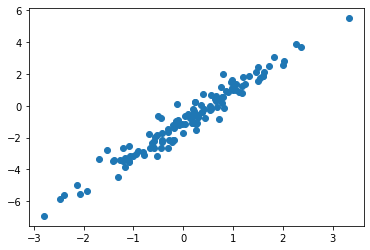

In [22]:
# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
# noise = 0
ys = xs * true_w + true_b + noise

plt.scatter(xs, ys)
plt.show()

In [23]:
# Initialise parameters and replicate across devices.
params = init_model(jax.random.PRNGKey(0))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
print(replicated_params)

# Prepare the data
def reshape_for_pmap(data, n_devices):
    return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])

x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

Params(weight=DeviceArray([0.14389051, 0.14389051, 0.14389051, 0.14389051, 0.14389051,
             0.14389051, 0.14389051, 0.14389051], dtype=float32), bias=DeviceArray([-1.2515285, -1.2515285, -1.2515285, -1.2515285, -1.2515285,
             -1.2515285, -1.2515285, -1.2515285], dtype=float32))
(8, 16, 1) (8, 16, 1)


## continued in the orginal notebook